# Time Series 


Time Series using **Darts**

`TimeSeries` represents a *univariate* or *multivariate* time series.

Time series 

Google's *TimesFM* 

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

In [23]:
series = AirPassengersDataset().load()

In [28]:
series.head()

<TimeSeries (DataArray) (Month: 5, component: 1, sample: 1)>
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1949-05-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='Month'>

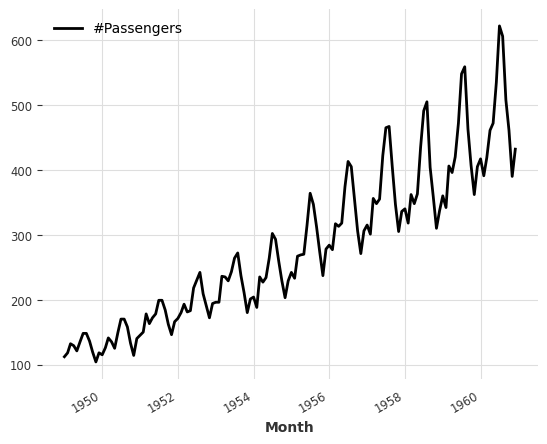

In [5]:
series.plot()

<Axes: xlabel='Month'>

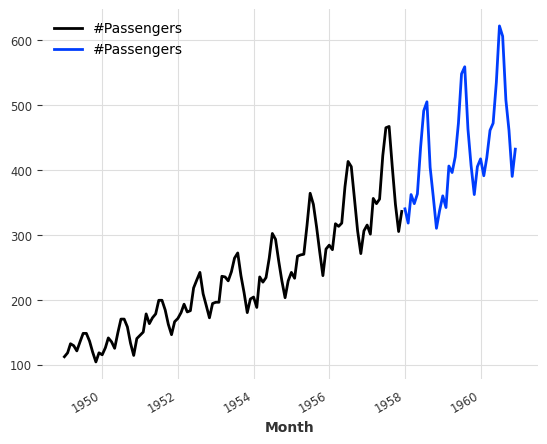

In [6]:
series1, series2 = series.split_after(0.75)
series1.plot()
series2.plot()

<Axes: xlabel='Month'>

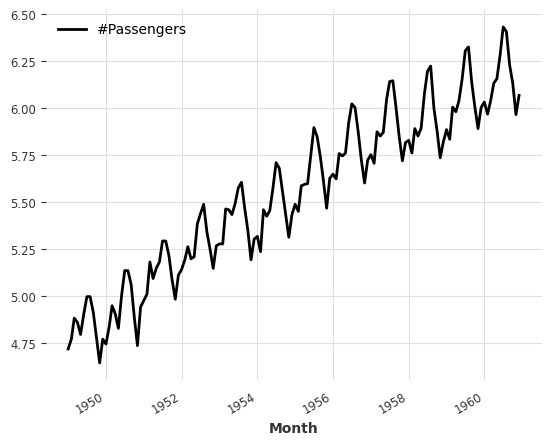

In [8]:
# Transform the data to logarithms
series.map(np.log).plot()

<Axes: xlabel='Month'>

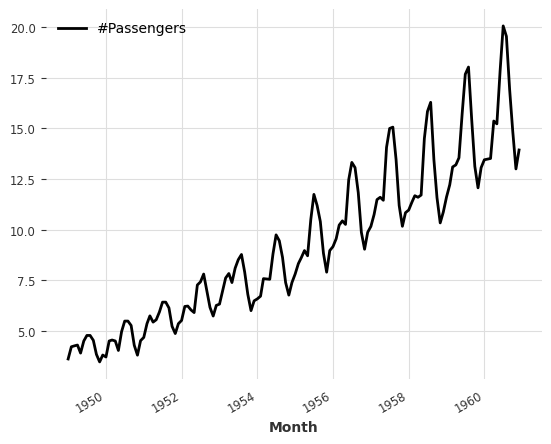

In [9]:
# get the number of passengers per day in each month
series.map(lambda ts, x: x / ts.days_in_month).plot()

<Axes: xlabel='Month'>

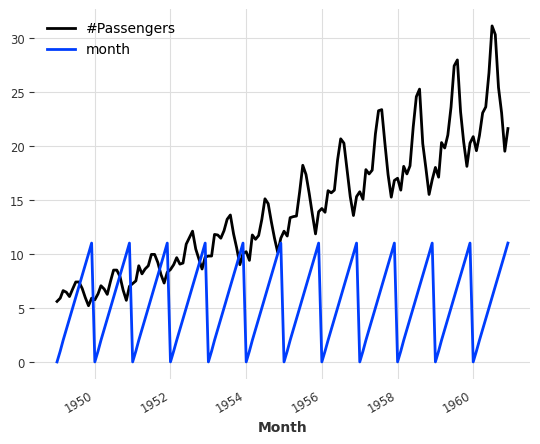

In [48]:
# add a month attribute
(series/20).add_datetime_attribute("month").plot()

<Axes: xlabel='Month'>

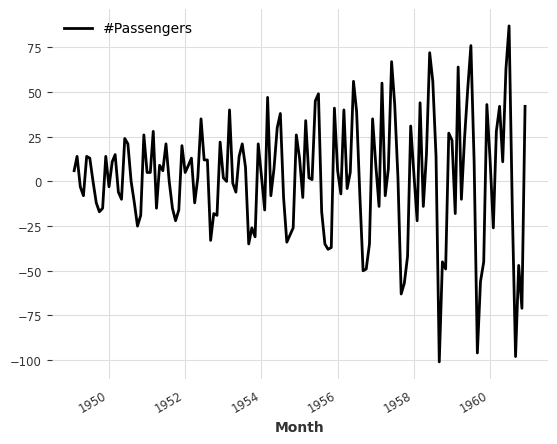

In [50]:
# get the first difference
series.diff().plot()

<Axes: xlabel='Month'>

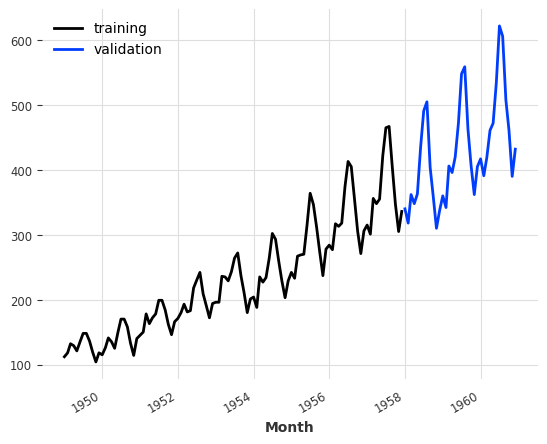

In [67]:
# Split into training and validation set by date
# train takes all data before 1958-01-01
# validation takes all data after 1958-01-01 and this day
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

## A toy example with two series

These models can be trained on thousands of series. Here, for the sake (for the purpose) of illustration, we will load two distinct series - the *air traffic passenger* count and another series containing the *number of pounds of milk produced per cow* monthly. We also cast our series to np.float32 as that will slightly speedup the training:

In [70]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

Next, we will build an N-BEATS model. This model can be tuned with many hyper-parameters (such as number of stacks, layers, etc). Here, for simplicity, we will use it with default hyper-parameters. The only two hyper-parameters that we have to provide are:

- **input_chunk_length**: this is the “lookback window” of the model - i.e., how many time steps of history the neural network takes as input to produce its output in a forward pass.

- **output_chunk_length**: this is the “forward window” of the model - i.e., how many time steps of future values the neural network outputs in a forward pass.

<Axes: xlabel='Month'>

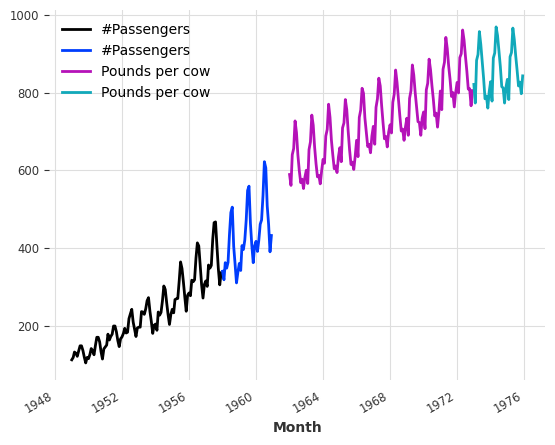

In [15]:
# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

<Axes: xlabel='Month'>

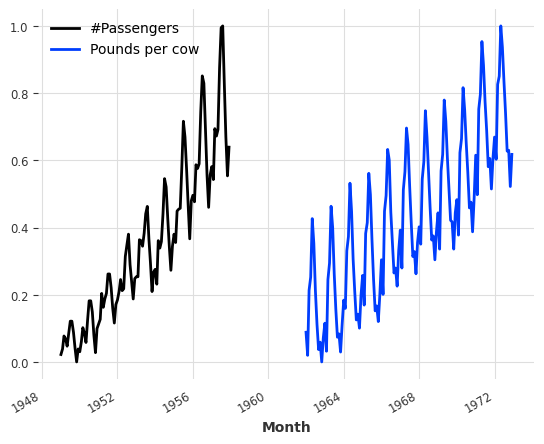

In [16]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

In [17]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

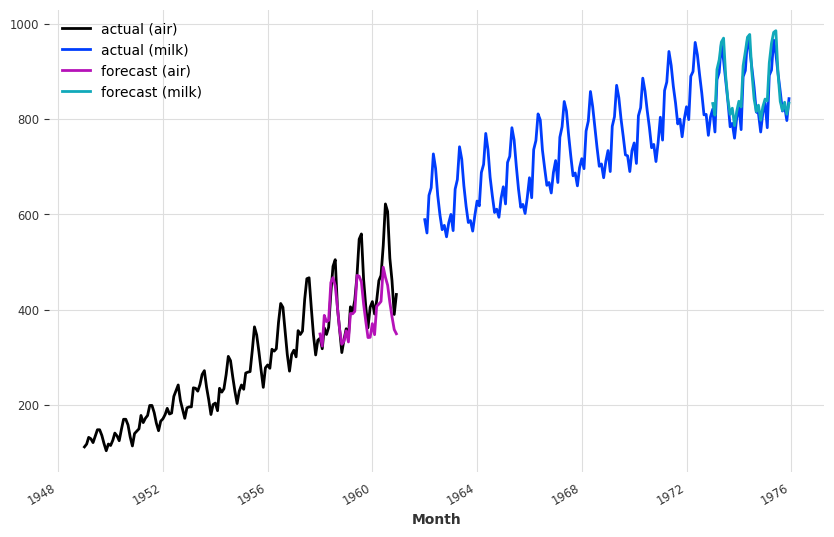

In [18]:
pred_air = model.predict(series=train_air_scaled, n=36)
pred_milk = model.predict(series=train_milk_scaled, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

Covariates

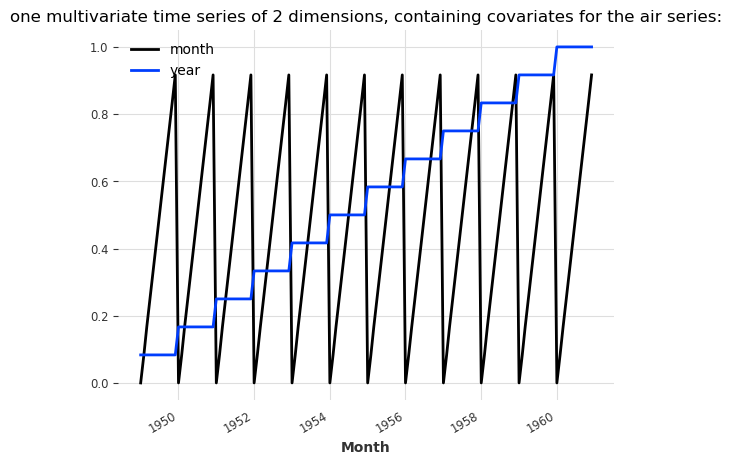

In [19]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series_air.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_air.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

milk_covs = concatenate(
    [
        dt_attr(series_milk.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_milk.time_index, "year", dtype=np.float32) - 1962) / 13,
    ],
    axis="component",
)

air_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
);

In [74]:
train_milk_scaled.__len__()

132

In [20]:
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    [train_air_scaled, train_milk_scaled],
    past_covariates=[air_covs, milk_covs],
    epochs=50,
    verbose=True,
);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

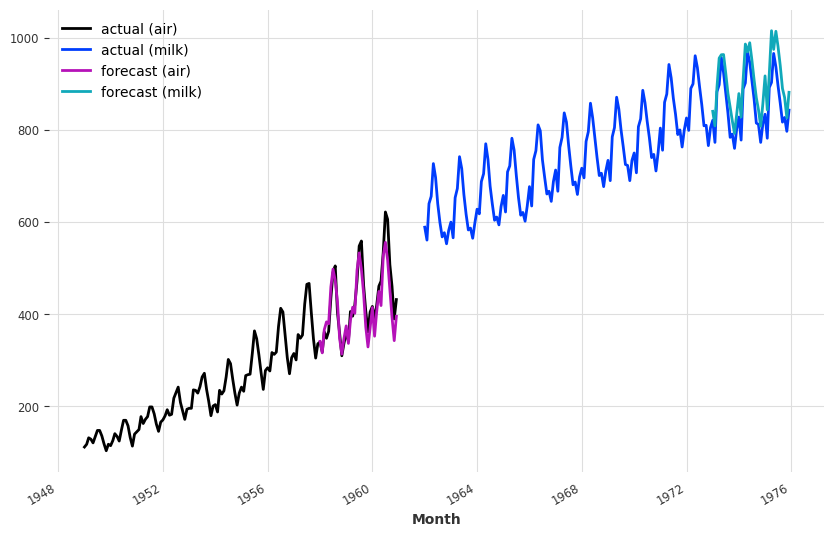

In [22]:
pred_air = model.predict(series=train_air_scaled, past_covariates=air_covs, n = 36) # n= 36
pred_milk = model.predict(series=train_milk_scaled, past_covariates=milk_covs, n=36) # n= 36

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")